# Introduction

In this project, you will build a neural network of your own design to evaluate the CIFAR-10 dataset.

To meet the requirements for this project, you will need to achieve an accuracy greater than 45%. 
If you want to beat Detectocorp's algorithm, you'll need to achieve an accuracy greater than 70%. 
(Beating Detectocorp's algorithm is not a requirement for passing this project, but you're encouraged to try!)

Some of the benchmark results on CIFAR-10 include:

78.9% Accuracy | [Deep Belief Networks; Krizhevsky, 2010](https://www.cs.toronto.edu/~kriz/conv-cifar10-aug2010.pdf)

90.6% Accuracy | [Maxout Networks; Goodfellow et al., 2013](https://arxiv.org/pdf/1302.4389.pdf)

96.0% Accuracy | [Wide Residual Networks; Zagoruyko et al., 2016](https://arxiv.org/pdf/1605.07146.pdf)

99.0% Accuracy | [GPipe; Huang et al., 2018](https://arxiv.org/pdf/1811.06965.pdf)

98.5% Accuracy | [Rethinking Recurrent Neural Networks and other Improvements for ImageClassification; Nguyen et al., 2020](https://arxiv.org/pdf/2007.15161.pdf)

Research with this dataset is ongoing. Notably, many of these networks are quite large and quite expensive to train. 

## Imports

In [25]:
## This cell contains the essential imports you will need – DO NOT CHANGE THE CONTENTS! ##
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

## Load the Dataset

Specify your transforms as a list first.
The transforms module is already loaded as `transforms`.

CIFAR-10 is fortunately included in the torchvision module.
Then, you can create your dataset using the `CIFAR10` object from `torchvision.datasets` ([the documentation is available here](https://pytorch.org/vision/stable/generated/torchvision.datasets.CIFAR10.html)).
Make sure to specify `download=True`! 

Once your dataset is created, you'll also need to define a `DataLoader` from the `torch.utils.data` module for both the train and the test set.

In [41]:
# Define transforms for data augmentation and normalization
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# Create training set and define training dataloader
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64,
                                          shuffle=True, num_workers=2)
# Define the validation set and data loader
valset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
valloader = torch.utils.data.DataLoader(valset, batch_size=64, shuffle=False)

# Create test set and define test dataloader
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=64,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Explore the Dataset
Using matplotlib, numpy, and torch, explore the dimensions of your data.

You can view images using the `show5` function defined below – it takes a data loader as an argument.
Remember that normalized images will look really weird to you! You may want to try changing your transforms to view images.
Typically using no transforms other than `toTensor()` works well for viewing – but not as well for training your network.
If `show5` doesn't work, go back and check your code for creating your data loaders and your training/test sets.

In [42]:
def show5(data_loader):
    data_iter = iter(data_loader)
    images, labels = data_iter.next()
    images = images.numpy()
    images = (images + 1) / 2
    fig, axes = plt.subplots(1, 5, figsize=(12, 2.5))
    for i in range(5):
        ax = axes[i]
        ax.imshow(np.transpose(images[i], (1, 2, 0)))
        ax.set_title(classes[labels[i]])
        ax.axis('off')
        plt.tight_layout()
    plt.show()

Train dataset length: 50000
torch.Size([3, 32, 32])


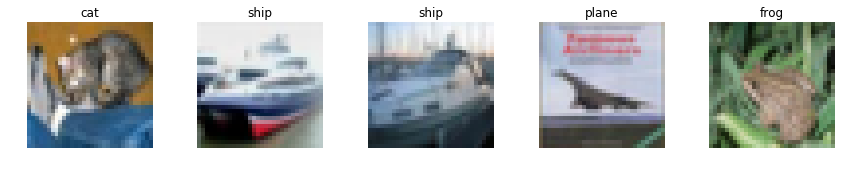

In [43]:
print("Train dataset length: " + str(len(trainset)))
sample = next(iter(trainset))
img, label = sample
print(img.shape)
show5(testloader)

## Build your Neural Network
Using the layers in `torch.nn` (which has been imported as `nn`) and the `torch.nn.functional` module (imported as `F`), construct a neural network based on the parameters of the dataset. 
Feel free to construct a model of any architecture – feedforward, convolutional, or even something more advanced!

Specify a loss function and an optimizer, and instantiate the model.

If you use a less common loss function, please note why you chose that loss function in a comment.

In [44]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input channels = 3, output channels = 16
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        # Input channels = 16, output channels = 32
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        # Input channels = 32*8*8, output channels = 10
        self.fc1 = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        # Use a max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # Use a max pooling over a (2, 2) window
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, 32 * 8 * 8)
        x = self.fc1(x)
        return x

# Instantiate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net().to(device)

# Define the loss function
criterion = nn.CrossEntropyLoss()

# Define the optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)


## Running your Neural Network
Use whatever method you like to train your neural network, and ensure you record the average loss at each epoch. 
Don't forget to use `torch.device()` and the `.to()` method for both your model and your data if you are using GPU!

If you want to print your loss during each epoch, you can use the `enumerate` function and print the loss after a set number of batches. 250 batches works well for most people!

In [50]:
epochs = 10
steps = 0
running_loss = 0
print_every = 250
train_losses, val_losses = [], []
for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        
        # Move input and label tensors to the default device
        inputs, labels = inputs.to(device), labels.to(device)
        
        # Clear the gradients
        optimizer.zero_grad()
        
        # Forward pass
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        # Backward pass
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            val_loss = 0
            accuracy = 0
            model.eval()
            with torch.no_grad():
                for inputs, labels in valloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = model.forward(inputs)
                    batch_loss = criterion(logps, labels)
                    
                    val_loss += batch_loss.item()
                    
                    # Calculate accuracy
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
            
            train_losses.append(running_loss/print_every)
            val_losses.append(val_loss/len(valloader))
            print("Epoch: {}/{}.. ".format(epoch+1, epochs),
                  "Training Loss: {:.3f}.. ".format(running_loss/print_every),
                  "Validation Loss: {:.3f}.. ".format(val_loss/len(valloader)),
                  "Validation Accuracy: {:.3f}".format(accuracy/len(valloader)))
            running_loss = 0
            model.train()
print('Finished Training')
  

Epoch: 1/10..  Training Loss: 1.220..  Validation Loss: 1.094..  Validation Accuracy: 0.622
Epoch: 1/10..  Training Loss: 1.226..  Validation Loss: 1.089..  Validation Accuracy: 0.618
Epoch: 1/10..  Training Loss: 1.207..  Validation Loss: 1.104..  Validation Accuracy: 0.613
Epoch: 2/10..  Training Loss: 1.208..  Validation Loss: 1.087..  Validation Accuracy: 0.619
Epoch: 2/10..  Training Loss: 1.201..  Validation Loss: 1.066..  Validation Accuracy: 0.631
Epoch: 2/10..  Training Loss: 1.197..  Validation Loss: 1.088..  Validation Accuracy: 0.618
Epoch: 3/10..  Training Loss: 1.192..  Validation Loss: 1.075..  Validation Accuracy: 0.625
Epoch: 3/10..  Training Loss: 1.182..  Validation Loss: 1.051..  Validation Accuracy: 0.634
Epoch: 3/10..  Training Loss: 1.184..  Validation Loss: 1.071..  Validation Accuracy: 0.625
Epoch: 4/10..  Training Loss: 1.174..  Validation Loss: 1.049..  Validation Accuracy: 0.636
Epoch: 4/10..  Training Loss: 1.164..  Validation Loss: 1.037..  Validation Accu

Plot the training loss (and validation loss/accuracy, if recorded).

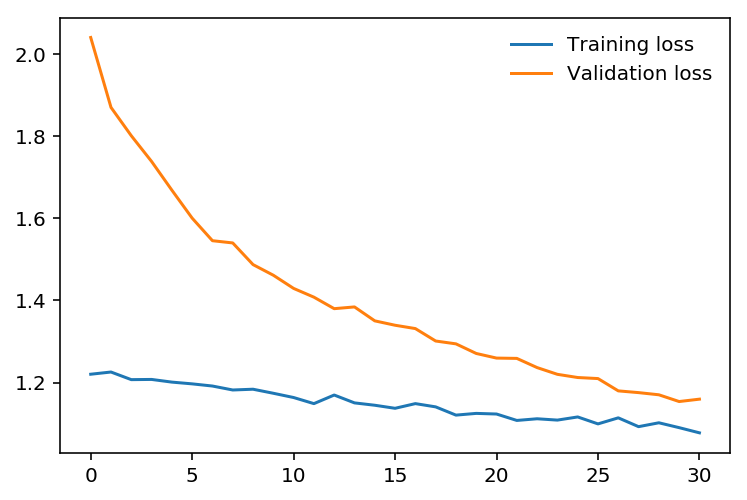

In [51]:
## YOUR CODE HERE ##
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

Param_range = np.arange(1,10)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Testing your model
Using the previously created `DataLoader` for the test set, compute the percentage of correct predictions using the highest probability prediction. 

If your accuracy is over 70%, great work! 
This is a hard task to exceed 70% on.

If your accuracy is under 45%, you'll need to make improvements.
Go back and check your model architecture, loss function, and optimizer to make sure they're appropriate for an image classification task.

In [52]:
## YOUR CODE HERE ##
test_loss = 0
accuracy = 0
model.eval()
with torch.no_grad():
    for inputs, labels in testloader:
        inputs, labels = inputs.to(device), labels.to(device)
        logps = model.forward(inputs)
        batch_loss = criterion(logps, labels)

        test_loss += batch_loss.item()

        # Calculate accuracy
        ps = torch.exp(logps)
        top_p, top_class = ps.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

print("Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
      "Test Accuracy: {:.3f}".format(accuracy/len(testloader)))


Test Loss: 0.967..  Test Accuracy: 0.662


## Saving your model
Using `torch.save`, save your model for future loading.

In [53]:
## YOUR CODE HERE ##
# Define the file path where you want to save the model
filepath = 'cifar_densenet121_model.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), filepath)

## Make a Recommendation

Based on your evaluation, what is your recommendation on whether to build or buy? Explain your reasoning below.

Some things to consider as you formulate your recommendation:
* How does your model compare to Detectocorp's model?
* How does it compare to the far more advanced solutions in the literature? 
* What did you do to get the accuracy you achieved? 
* Is it necessary to improve this accuracy? If so, what sort of work would be involved in improving it?



Detectocorp's algorithm achieves a 70% accuracy rate, which is higher than the 66.2% accuracy rate achieved by the model my trained. Therefore, buying Detectocorp's algorithm might seem like the best option, given that it is more accurate than the model my trained. However, there are a few things to consider.

Firstly, it is essential to understand the specific use case and requirements of the product. If the product requires high accuracy, it might be necessary to invest in building a more accurate model. In such a case, you could consider incorporating advanced techniques such as transfer learning, ensembling, or more data to improve your model's accuracy.

Secondly, it is crucial to evaluate the cost-benefit analysis of building vs. buying the algorithm. While building a more accurate model might provide better performance, it also comes with a higher cost in terms of time, effort, and resources. On the other hand, buying an algorithm from a vendor might be a more cost-effective solution, especially if the vendor provides support and maintenance.

Lastly, you need to consider the availability of expertise and resources within your organization. Building a complex machine learning algorithm requires a team of experienced data scientists and engineers who are skilled in machine learning, data preprocessing, and model optimization. If your organization does not have the necessary expertise, buying an algorithm from a vendor might be the best option.

In conclusion, the decision to build or buy an algorithm depends on several factors, including the use case, accuracy requirements, cost-benefit analysis, and availability of resources. It is crucial to carefully evaluate these factors before making a decision.



## Submit Your Project

When you are finished editing the notebook and are ready to turn it in, simply click the **SUBMIT PROJECT** button in the lower right.

Once you submit your project, we'll review your work and give you feedback if there's anything that you need to work on. If you'd like to see the exact points that your reviewer will check for when looking at your work, you can have a look over the project [rubric](https://review.udacity.com/#!/rubrics/3077/view).